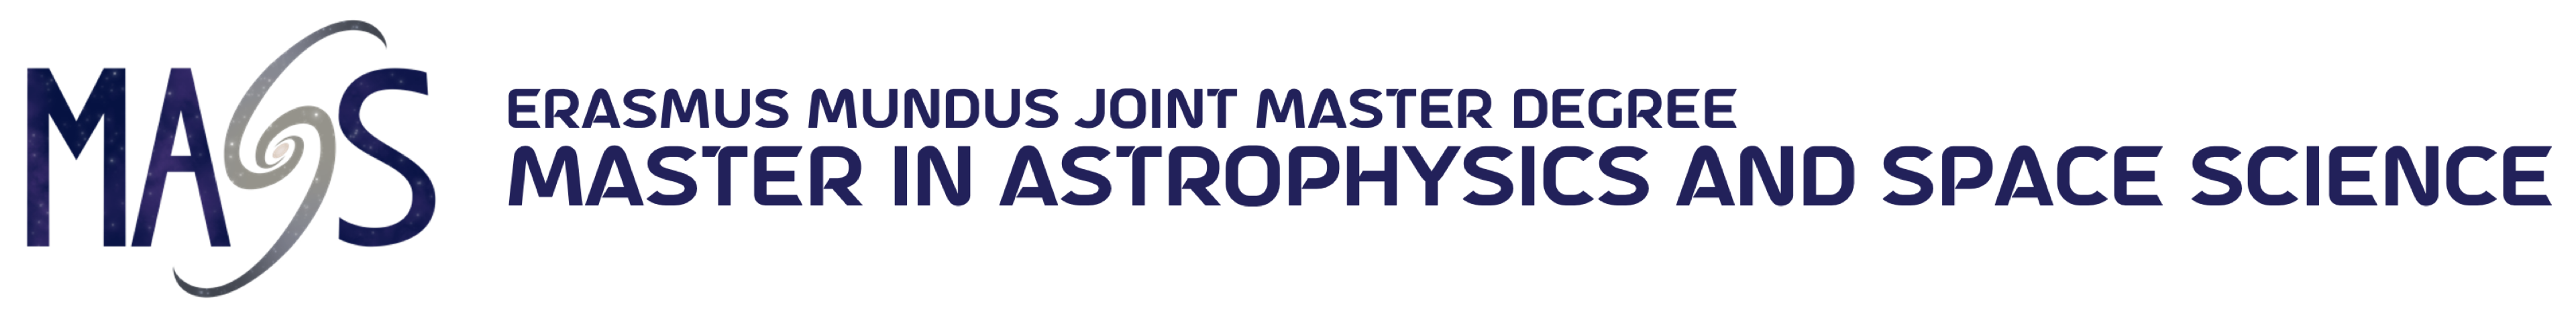

# SED Fitting of GRBs

## HW #6: Data processing of X-ray and UV/optical observations from the SWIFT observatory

11 Dec 2024

Student: Francesca Borg

Instructor: Prof. Dragana Ilić

In this notebook, we fit the spectral energy distribution (SED) of a gamma-ray burst (GRB) following the procedure in the above mentioned tutorial.

## 3. SED of GRB

### 3.1 Downloading data

From the GRB library [1] we choose **2013fu**, also known as **GRB 130831A**, which lies at the following coordinates.

| | GRB 130831A  |
|--|-----------|
|RA |23:54:29.890|
|DEC |+29:25:46.200	|

Using the SWIFT data search tool [2], we search for the images of this event:

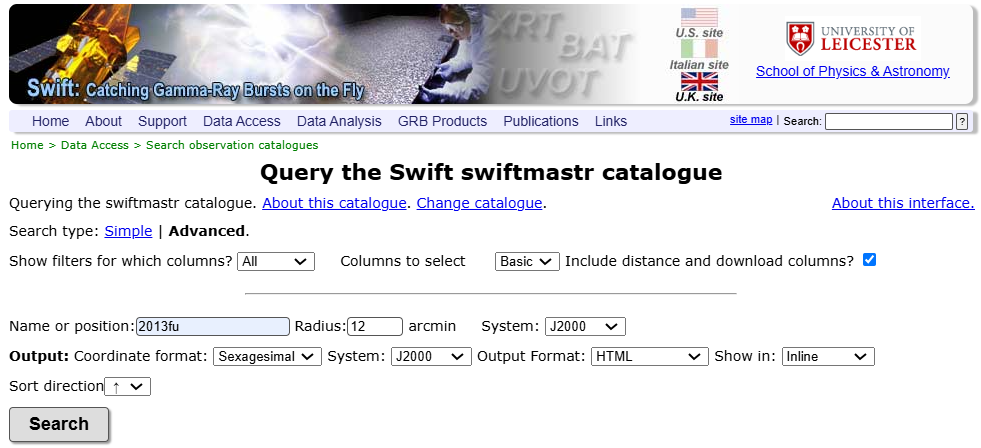

and select the following bands to retreive:

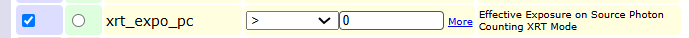

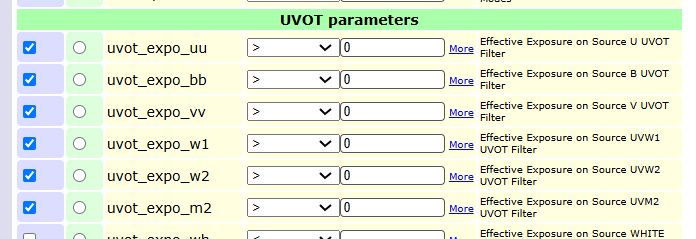

After submitting the 'Search', we obtain different observations of the same GRB, and select the one with highest exposure time in most filters. This requirement is purely statistical, aiming for the most accurate flux measurements.

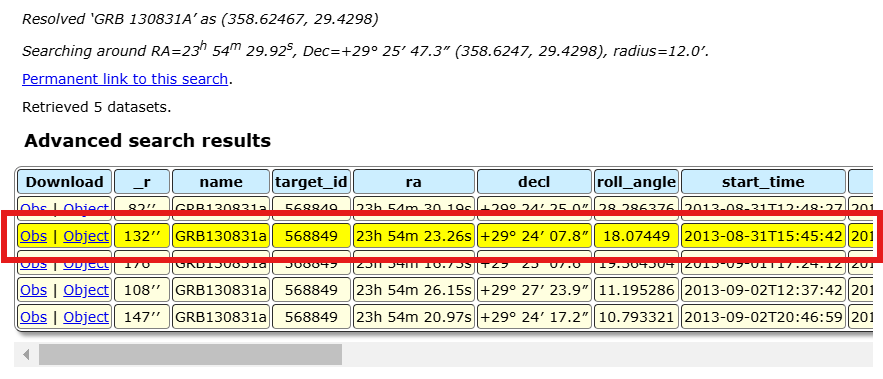

Clicking 'Obs' will take us to the observation data which we can select and download from. We select the data from the UVOT instrument of the image type. These images have the following naming scheme:
```
 sw[id observation]u[filter]_sk.img
```
where: u- denotes UVOT observations; [filter]- indicates which filter (U- uu, B- bb, V- vv, UW1-w1, UW2-w2, UM2-m2); sk- denotes images calibrated to based on the object equatorial coordinates for epoch J2000. For each filter, we have one image like this.

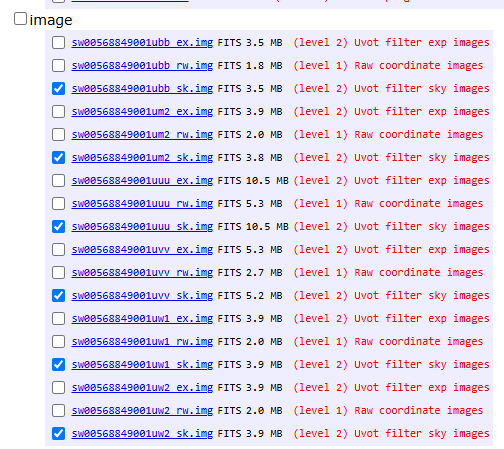

Next, we find event images obtained with the `XRT` instrument which have names following the scheme:
```
 sw[id observation]xpcw[some number]po_cl.evt
```
where: x- indicates that the XRT observations; pc- denotes detection in PC mode; po- telescope was pointing directly to the object; cl- data are reduced and ready for the extraction of the spectrum, image, light curve, etc. (depending on the detection mode); .evt- indicates that this is the event type of image. We select the corresponding image.

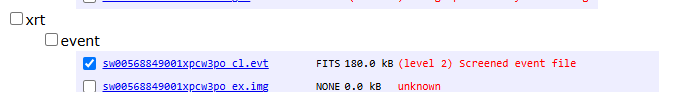

After appropriate selection, we download all selected files.

### 3.2 Extracting X-ray spectra

After extracting the event file _sw00568849001xpcw3po_cl.evt_ from `xrt/event`, we load it into SAO Image ds9, where we select circular regions of radius 47" around the source and some background region, and save them accordingly (in physical coordinates). The background reflects the background signal in the vicinity of the source, which is why we take this region not too far from the source.

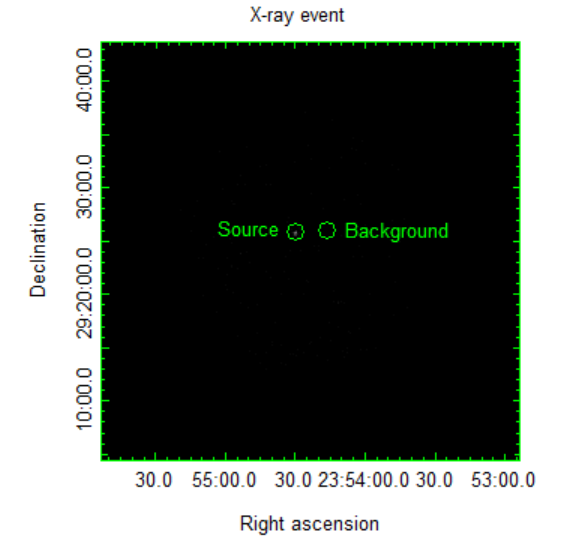

Next, we will use the HEASOFT software through a container hosted on SciServer.

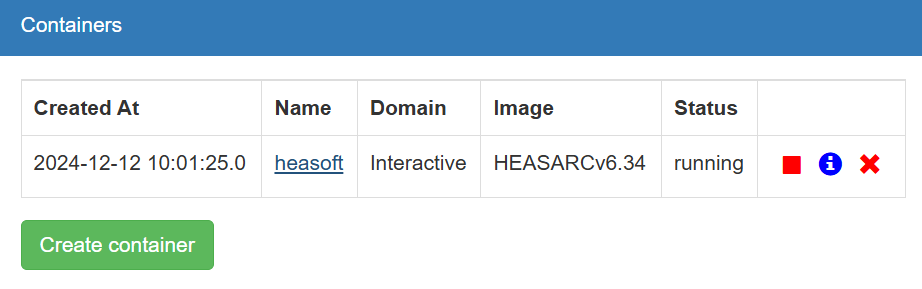

In order to extract the spectra from our selected regions using `xselect`, we run the following commands:
```
xselect

read event sw01186032001xpcw3po_cl.evt

set image sky
filter region grb_region_xray.reg
extract spectrum
save spectrum xrt_src.pha

clear region

filter region background_region_xray.reg
extract spectrum
save spectrum xrt_bkg.pha

exit
```

Now, we have extracted source and background spectra. The next step is downloading calibration files _swxpc0to12s6 20130101v014.rmf_ and _swxs6 20010101v001.arf_ from [3] to obtain a realistic source spectrum.

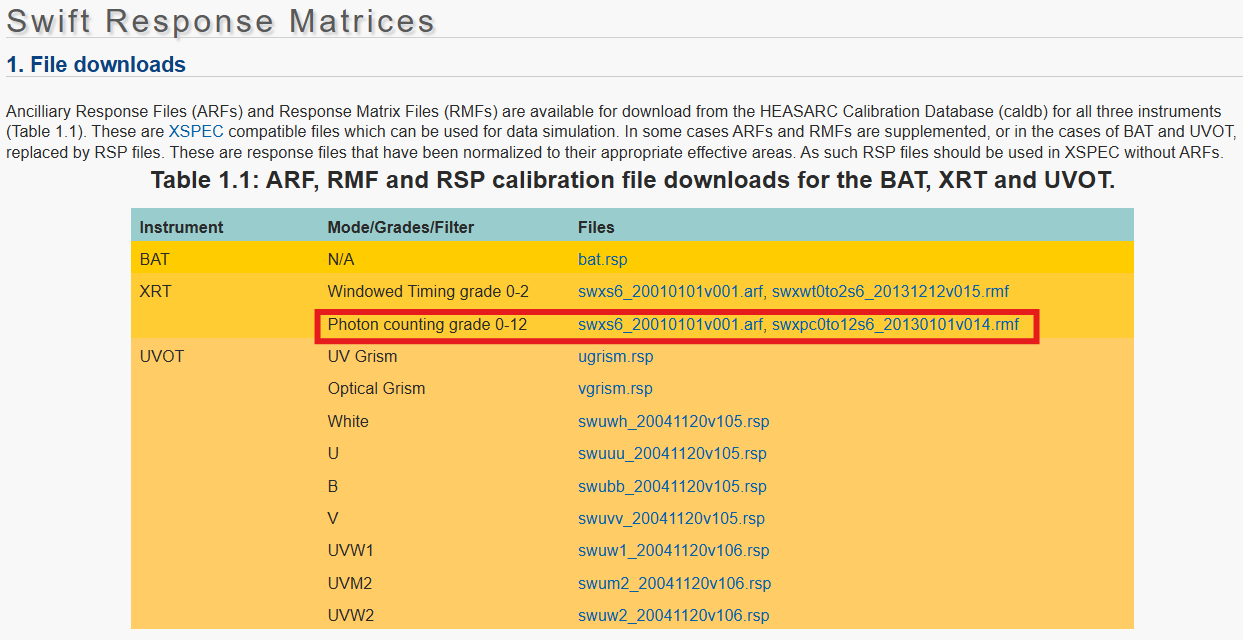

The next task is to use `grppha` package to group all these files into one to let XSPEC know which file represents the source and background spectra, and which ones are the calibration files. To do this, we run the following:

```
grppha
xrt_src.pha
xrt.pi
bad 0-29
group min 20
chkey RESPFILE swxpc0to12s6_20130101v014.rmf
chkey ANCRFILE swxs6_20010101v001.arf
chkey BACKFILE xrt_bkg.pha
exit
```

The result from this if the file _xrt.pi_ where the header contains keywords (RESPFILE, ANCRFILE, BACKFILE) that are pointing to the corresponding calibration files and background spectrum. With the bad command, we excluded the first 30 channels in the spectrum from consideration onwards, corresponding to energy less than 0.3,keV (it is recommended to exclude this part of the spectrum as it is not reliable). With the group command, we grouped the data into bins with at least 20 measurements each. This is recommended since we will later use a chi-squared test to fit the spectrum.

We now extracted the X-ray spectrum of the GRB.

We extract the following six files from `uvot/image`, which contain the images in the GRB in our selected filters:

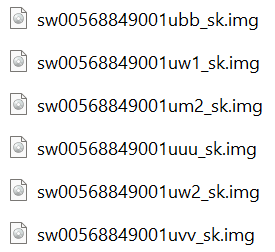

Next, we use the package `uvotimsum` on each of the six images as follows:
```
 TEMPLATE
 uvotimsum sw[id observation]u[filter]_sk.img u[filter]_sum.fits chatter=1

 W1
 uvotimsum sw00568849001uw1_sk.img uw1_sum.fits chatter = 1

 W2
 uvotimsum sw00568849001uw2_sk.img uw2_sum.fits chatter = 1

 UU
 uvotimsum sw00568849001uuu_sk.img uuu_sum.fits chatter = 1

 BB
 uvotimsum sw00568849001ubb_sk.img ubb_sum.fits chatter = 1

 VV
 uvotimsum sw00568849001uvv_sk.img uvv_sum.fits chatter = 1

 M2
 uvotimsum sw00568849001um2_sk.img um2_sum.fits chatter = 1

```
which returns a summed GRB image in the given filter in the _.fits_ format.

To use the summed images in the `XSPEC` package to extract their spectra, we need to convert them to `.pha` format.

For each of our _.fits_ images, we first need to select and save regions around our sources (`src`), as well as background regions, as done previously, using the coordinates [1] to locate the source and taking a same-size background region close by.

The selections made are illustrated below:

B-band

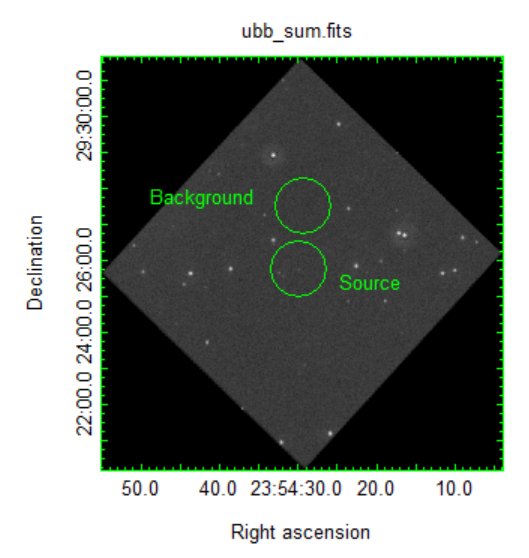

M2-band

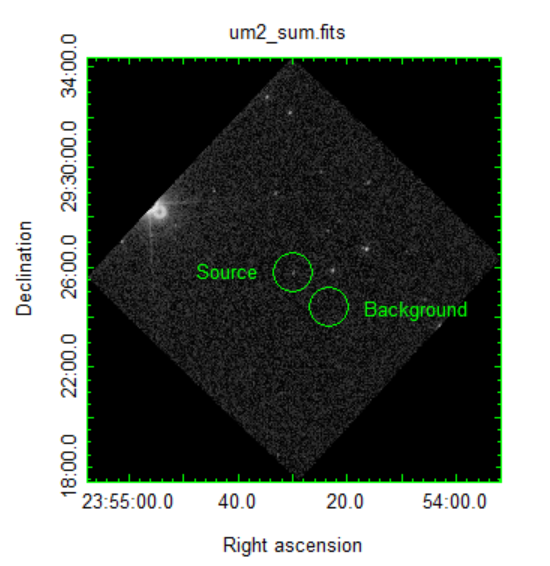

V-band

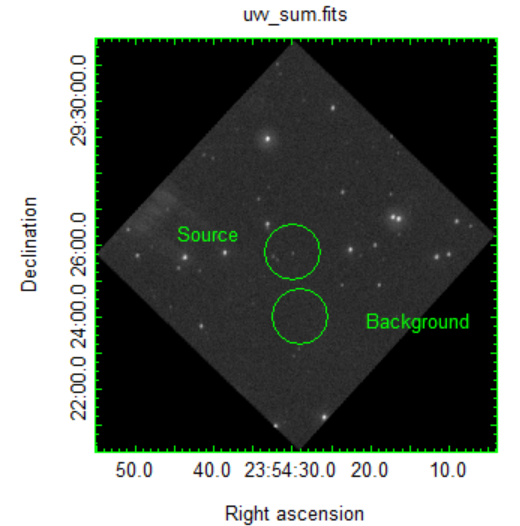

W1-band

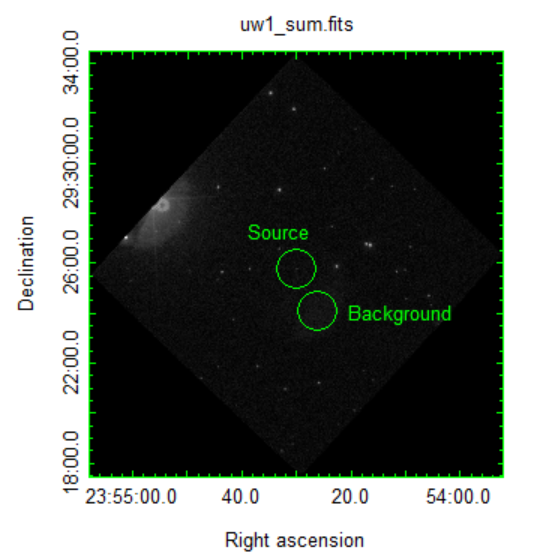

U-band

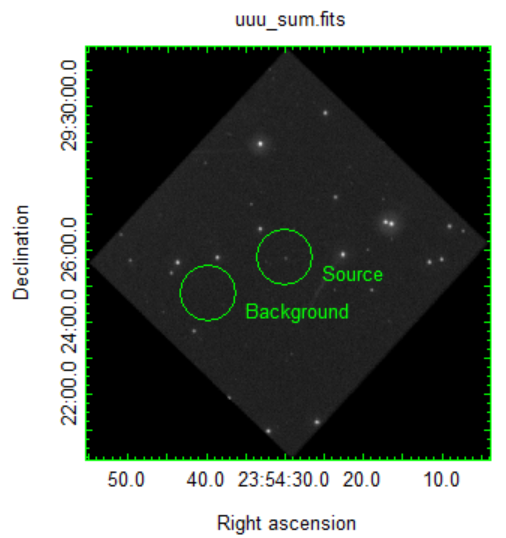

W2-band

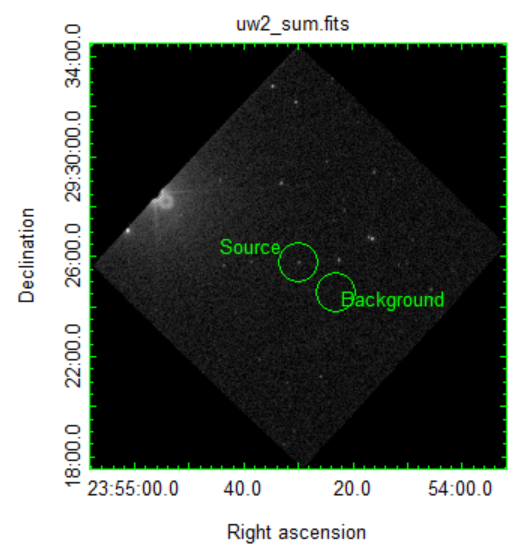

Before converting the summed images into _.pha_ files, we need to download calibration files from [3]. For each filter, we will have one _.rsp_ file:

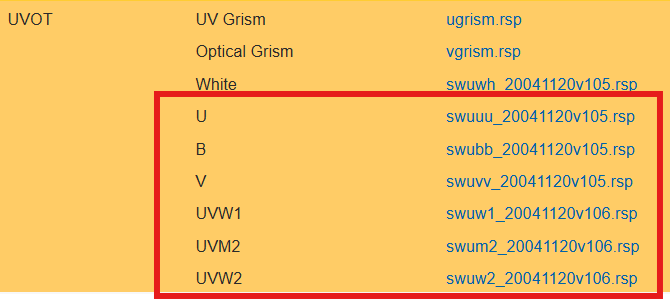

Now, we run the following command for each of the filters.
```
TEMPLATE:
uvot2pha infile=u[filter]_sum.fits srcpha=[filter].pha bkgpha=[filter]_bkg.pha srcreg=u[filter]_src.reg bkgreg=u[filter]_bkg.reg respfile=[filter].rsp clobber=y chatter=1

UBB
uvot2pha infile=ubb_sum.fits srcpha=ubb.pha bkgpha=ubb_bkg.pha srcreg=ubb_src.reg bkgreg=ubb_bkg.reg respfile=swubb_20041120v105.rsp clobber=y chatter=1

UM2
uvot2pha infile=um2_sum.fits srcpha=um2.pha bkgpha=um2_bkg.pha srcreg=um2_src.reg bkgreg=um2_bkg.reg respfile=swum2_20041120v106.rsp clobber=y chatter=1

UUU
uvot2pha infile=uuu_sum.fits srcpha=uuu.pha bkgpha=uuu_bkg.pha srcreg=uuu_src.reg bkgreg=uuu_bkg.reg respfile=swuuu_20041120v105.rsp clobber=y chatter=1

UVV
uvot2pha infile=uvv_sum.fits srcpha=uvv.pha bkgpha=uvv_bkg.pha srcreg=uvv_src.reg bkgreg=uvv_bkg.reg respfile=swuvv_20041120v105.rsp clobber=y chatter=1

UW1
uvot2pha infile=uw1_sum.fits srcpha=uw1.pha bkgpha=uw1_bkg.pha srcreg=uw1_src.reg bkgreg=uw1_bkg.reg respfile=swuw1_20041120v106.rsp clobber=y chatter=1

UW2
uvot2pha infile=uw2_sum.fits srcpha=uw2.pha bkgpha=uw2_bkg.pha srcreg=uw2_src.reg bkgreg=uw2_bkg.reg respfile=swuw2_20041120v106.rsp clobber=y chatter=1
```

Which creates the files that we can use to plot the SED curve of the GRB.

## 3.4 SED of GRB

### 3.4.2 `XSPEC` modelling of SED

`XSPEC` assumes the shape of the spectrum, calculates the following integral according to the response function for the given energy range (UV/optical or X), and compares the modeled spectrum with the observed one. Using a chi-squared $χ^2$ minimization the best fitting parameters of the selected model are obtained.

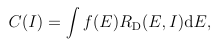

C(I) is the number of photons per unit time detected in a given energy channel I, f(E) is the intrinsic observed spectrum of the source, and $R_D$(E,I) is the system response function, representing the probability that a photon of energy E is detected in channel I.

It is worth noting that the response function, as defined, is a continuous function of energy. To model the spectrum, it is necessary to discretize the response function by detected radiation energy. It then becomes a matrix called the response matrix. For each of the filters we will use, there is one response matrix with the extension .rsp.

In the case of the XRT instrument, for the PC mode, files .rmf and .arf are given. The first file represents the normalized response matrix, while the second contains the coefficient by which to multiply the elements of the normalized response matrix to obtain the corresponding response matrix. These files are collectively referred to as **calibration files**.

## 3.5 Fitting the SED of GRB

We now load the data extracted from X and UV/optical images into `XSPEC` to plot the SED and fit the model.

```
xspec
data 1:1 uuu.pha 1:2 ubb.pha 1:3 uvv.pha 1:4 uw1.pha 1:5 uw2.pha 1:6 um2.pha 2:7 xrt.pi

cpd /png
setplot en
plot ldata
```

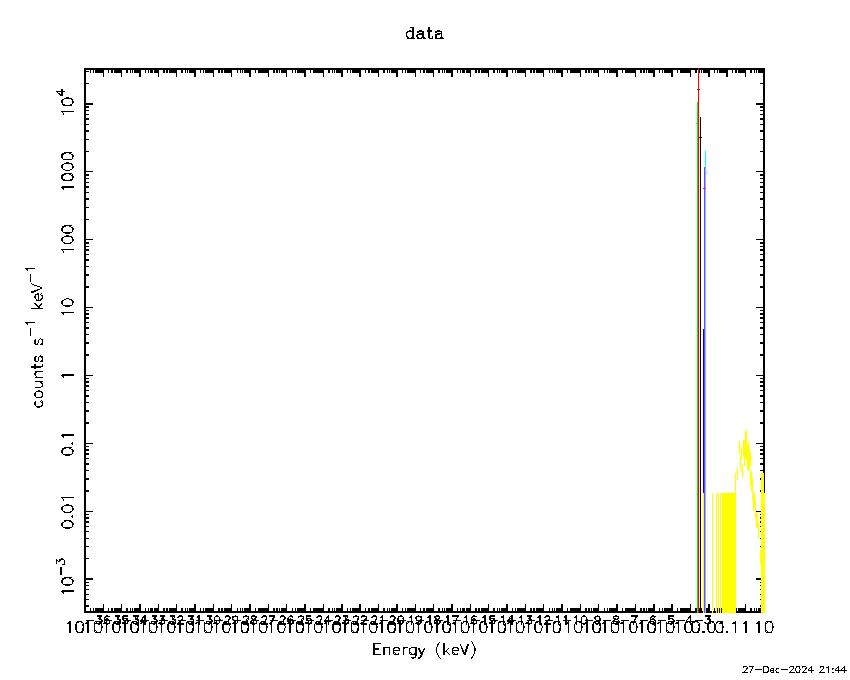

To ignore the channels previously marked as bad and 'zoom in' on the lines on the bottom-right side of the plot:

```
ignore bad
ignore 5.4-**
```

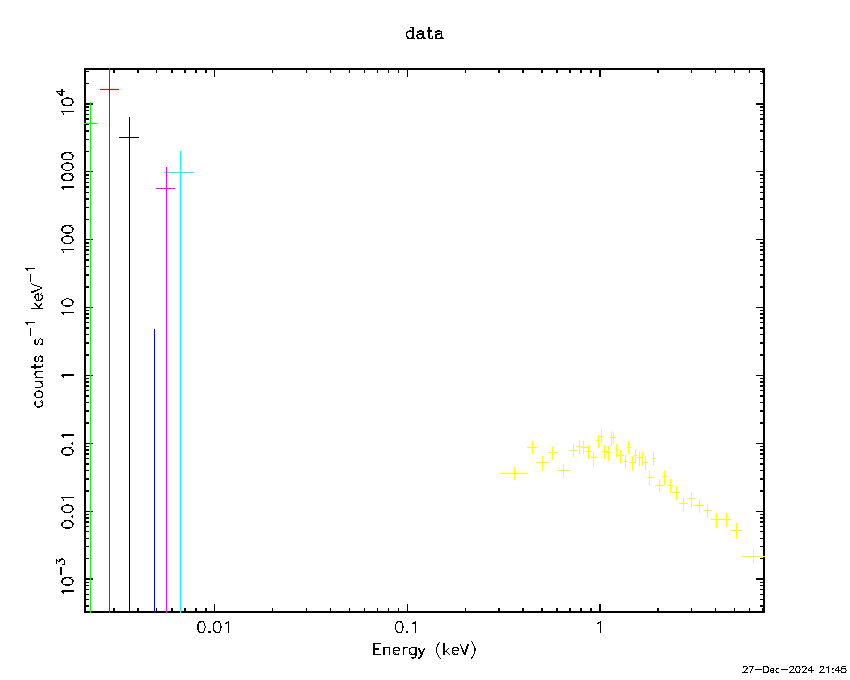

Note that the opposite of `ignore` is `notice`.

To perform the fitting we run:
```
 model phabs*powerlaw
 1:data group 1::phabs:nH>1
 2:data group 1::powerlaw:PhoIndex>
 3:data group 1::powerlaw:norm>
 4:data group 2::phabs:nH>2
 5:data group 2::powerlaw:PhoIndex>1.5
 6:data group 2::powerlaw:norm>1e4
```

`renorm` to change the `norm` parameter for both groups and optimize the input parameters, which should decrease the chi-squared statistic.

`plot` to examine the fitted line vs. the data points.

`fit 100` to increase the limit of number of fitting attempts to 100 from the default 10.

Finally, the fitting provides the final model parameters with uncertainties (provided in the form of a covariance matrix).

`plot ldata residual` to plot the difference between the SED and corresponding fitted model.

Next, we run the interactive plot to modify the axes and plot title as necessary:
```
iplot

la x Energy (keV)
la y Counts s=1keV=1
la top SED of GRB 130831A
time off
plot
hardcopy grb_sed.ps/cps
```

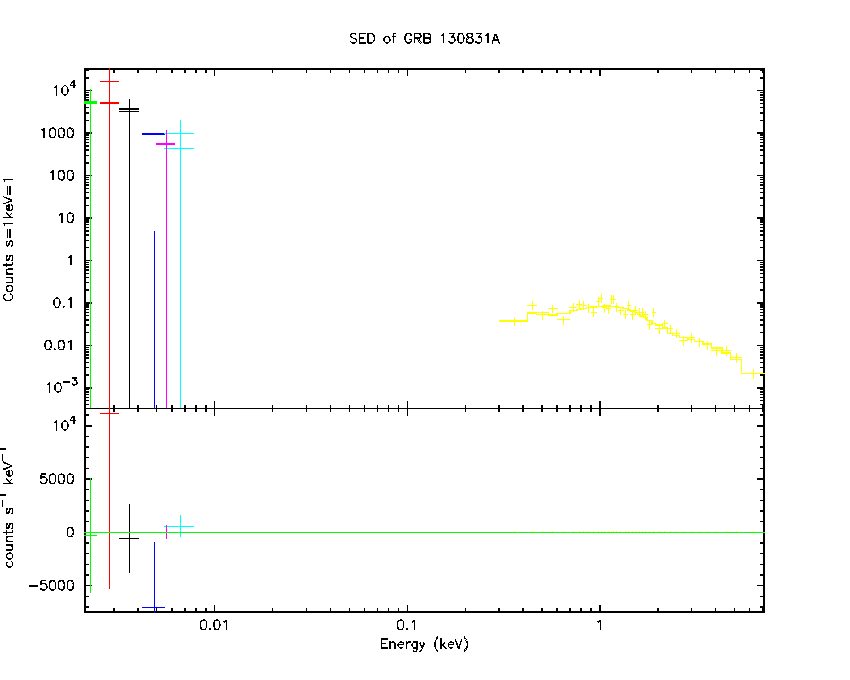

We can also change the colors used for plotting as follows:
```
color 1 on 13
color 2 on 14
```
which gives us our final result:

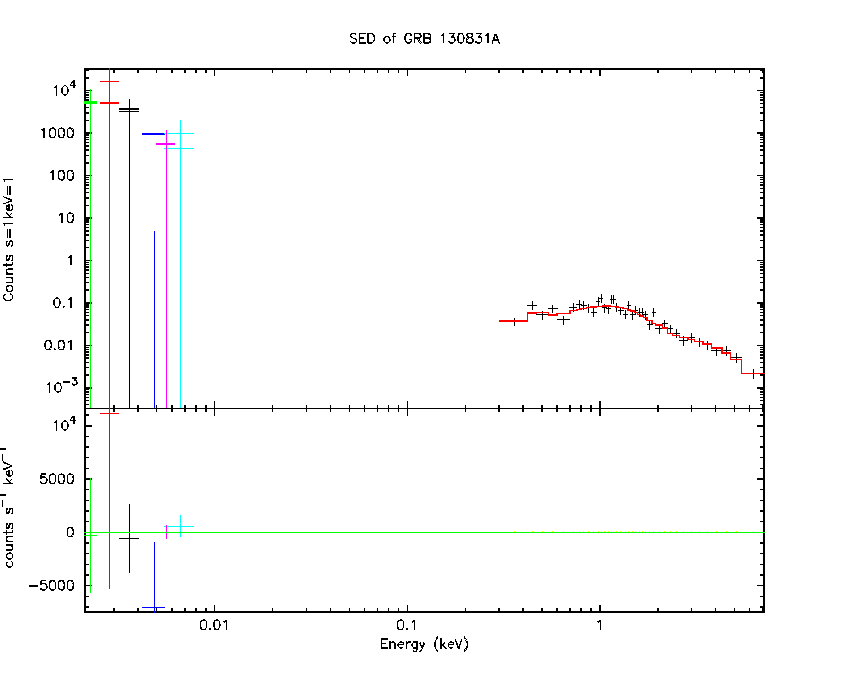

# References

[1] GRB Library: https://www.rochesterastronomy.org/snimages/grblist.html

[2] SWIFT data search tool: https://www.swift.ac.uk/swift_live/index.php#advanced

[3] Calibration files: https://swift.gsfc.nasa.gov/proposals/swift_responses.html